In [5]:
#STEP 1: importing all needed moduels

import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

Made changes to pyscneic code from np.object to object as recommended by compiler (it said nothing will be impacted)
![Screenshot 2023-07-12 at 1.04.47 PM.png](<attachment:Screenshot 2023-07-12 at 1.04.47 PM.png>)
This allows us to still use numpy 1.24.3 
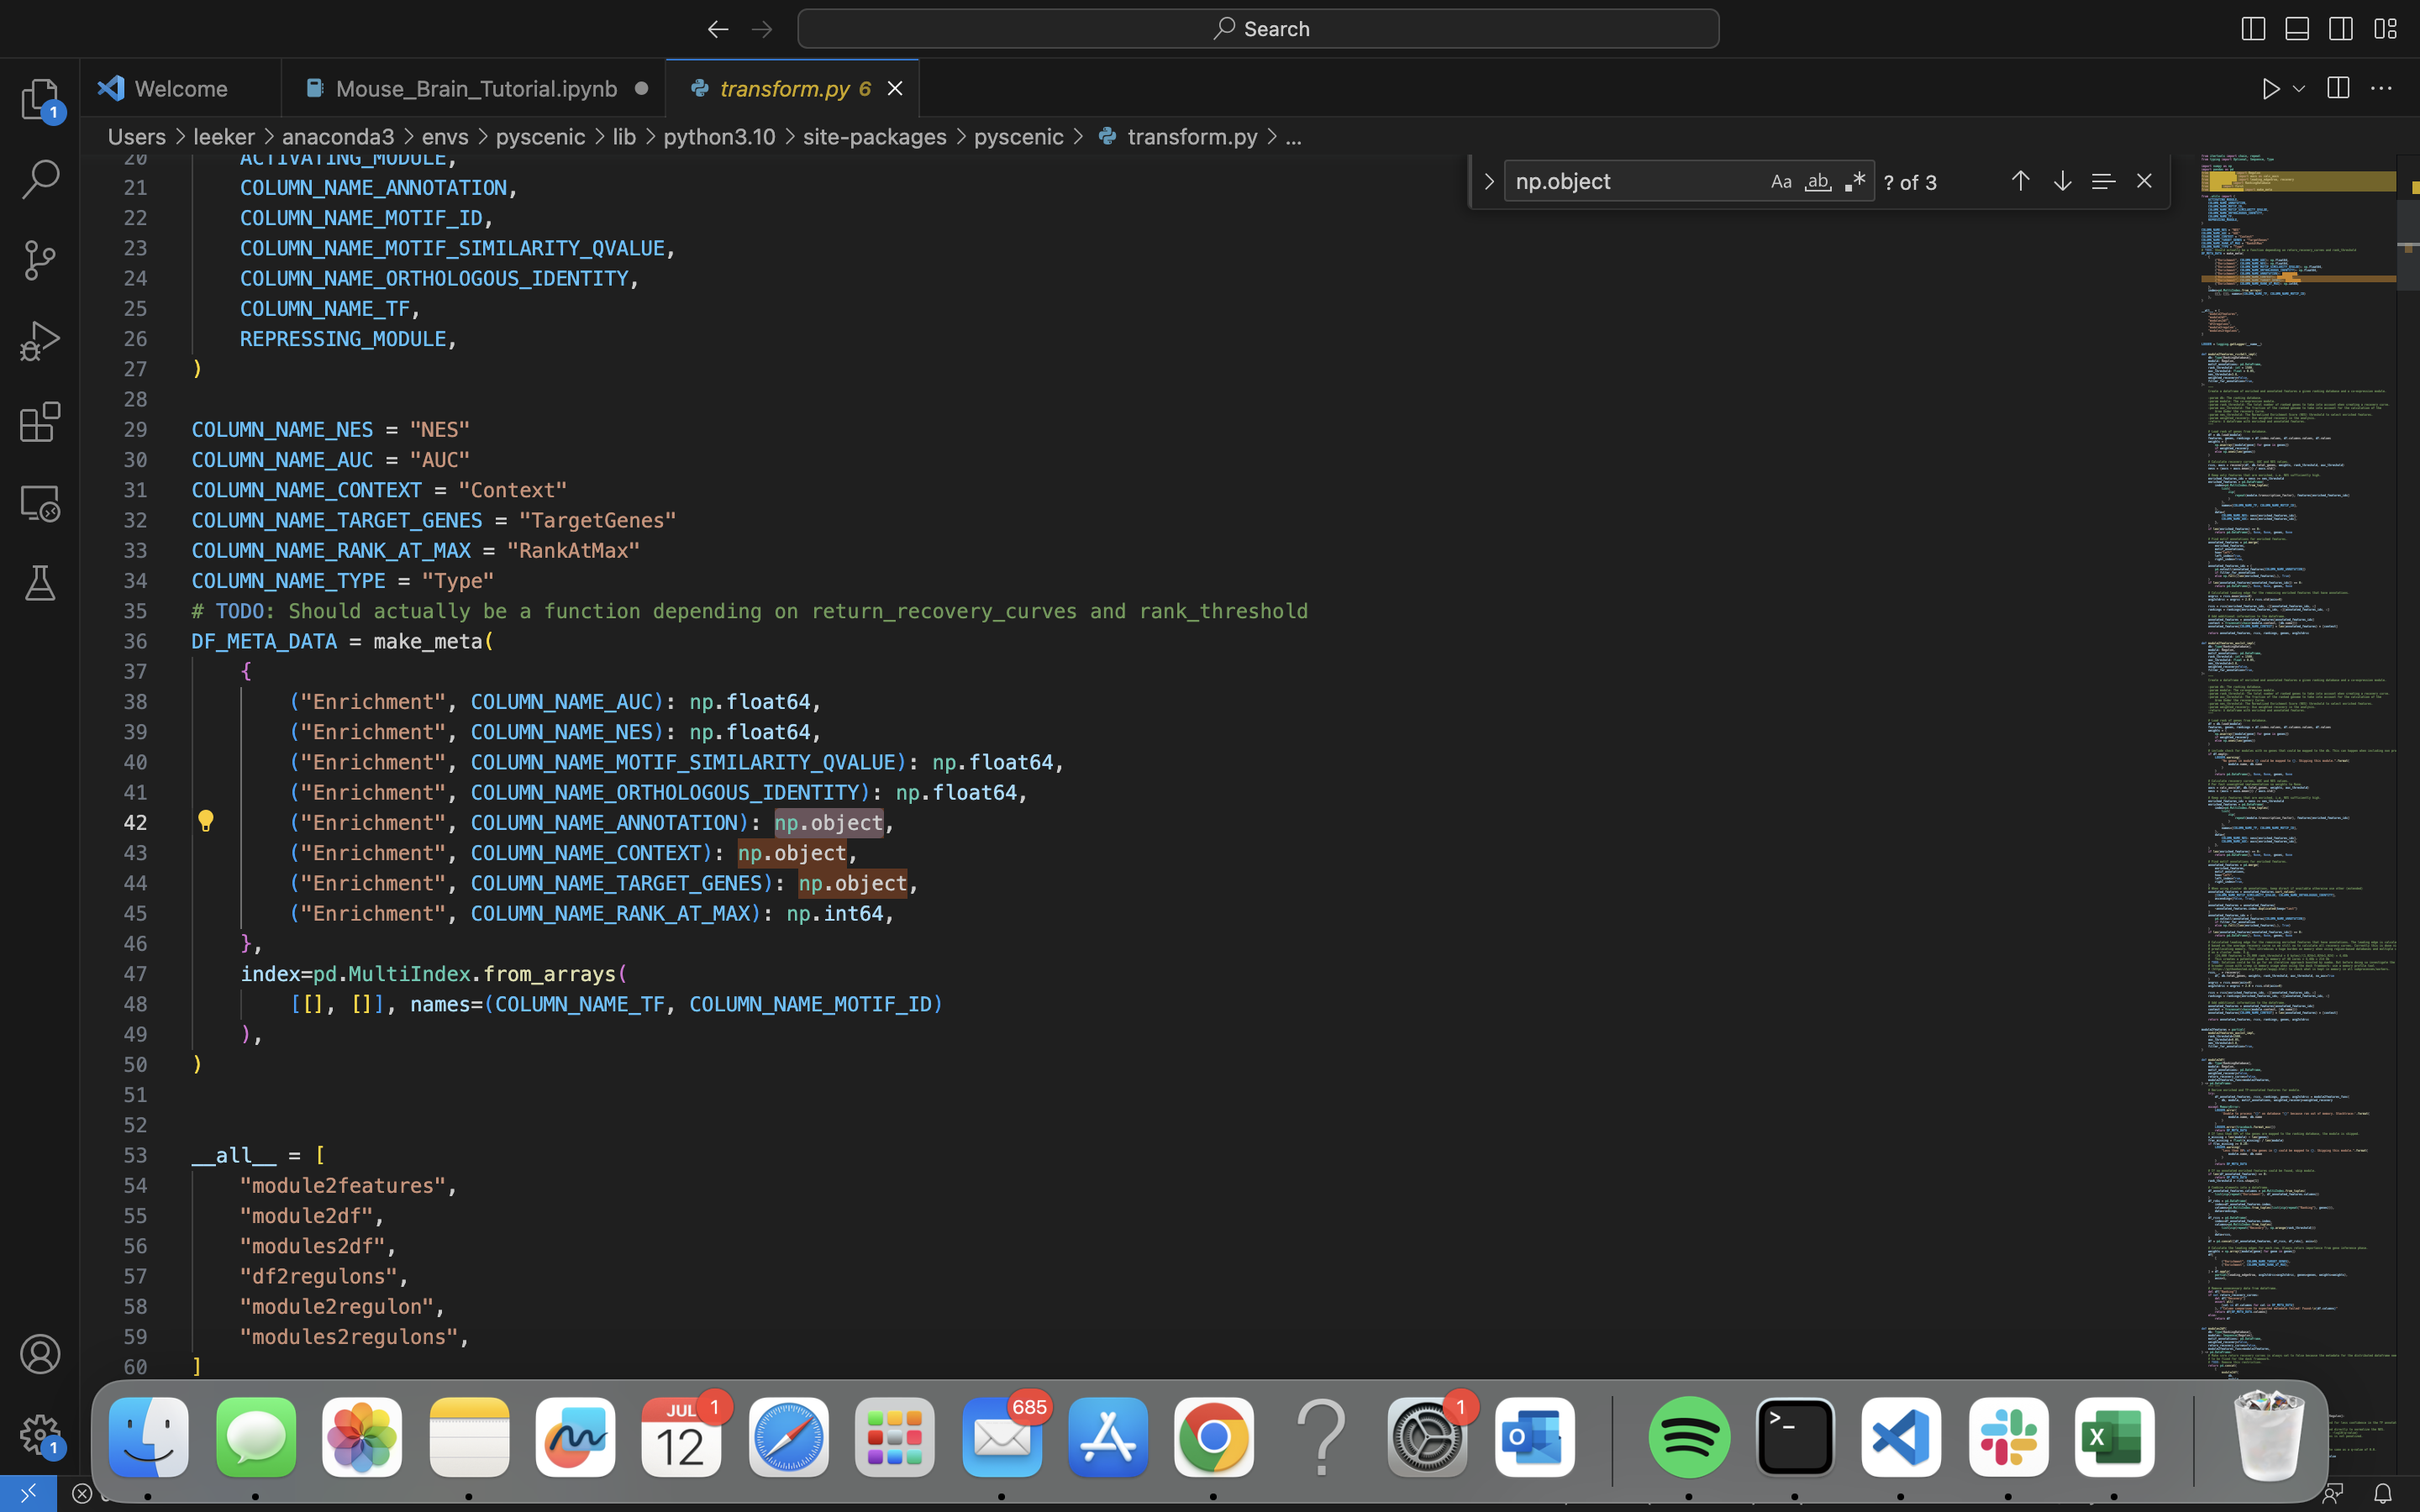

In [6]:
#STEP 1+: Set maximum number of jobs
sc.settings.njobs = 32

In [7]:
#STEP 1++: preparing pathway constant variables for easy coding

RESOURCES_FOLDERNAME = "/Users/leeker/Documents/MSKCC/Project/Tutorial/Mouse_Tutorial/resources"
RESULTS_FOLDERNAME = "/Users/leeker/Documents/MSKCC/Project/Tutorial/Mouse_Tutorial/results"
FIGURES_FOLDERNAME = "/Users/leeker/Documents/MSKCC/Project/Tutorial/Mouse_Tutorial/figures"
AUXILLIARIES_FOLDERNAME = "/Users/leeker/Documents/MSKCC/Project/Tutorial/Mouse_Tutorial/auxilliaries"

In [8]:
#STEP 2: importing important data files with motif ranking and transcription factor list
#input: Motif annotation files + database ranking files

# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/ (July 5th 2023)
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['mm9-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
                       'mm9-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
                        'mm9-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather']))

# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/ (July 5th 2023)
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')

In [9]:
#prepping
DATASET_ID = 'GSE60361'

In [10]:
#STEP 4: Downloading metadata and expression matrix
#input: expression matrix and metadata file

# Downloaded expression matrix from GEO (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361). (July 5th 2023)
#organized by cell ID and Gene matrix, values are counts of read in that cell
COUNTS_MTX_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'GSE60361_C1-3005-Expression.txt')
# Downloaded metadata from http://linnarssonlab.org/cortex/ 
METADATA_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'expression_mRNA_17-Aug-2014.txt')
#parsing Motif annotation file for list for unique transcription factors (from step 3)
MM_TFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'mm_tfs.txt')

# Output file
COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, 'GSE60361.qc.counts.csv')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.loom'.format(DATASET_ID))

In [11]:
#STEP 5: Create a txt file with the list of M. musculus transcription factors
pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')

#parses through pd_motifs to isolate the column with transcription factor name, output number of tfs, expected on tutorial is 1721
mm_tfs = pd_motifs.gene_name.unique()
len(mm_tfs)

#writing out the list of transcription factors to resource file
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

/var/folders/t0/yj5s320n6gq4pztncx0hwgq00000gn/T/ipykernel_17149/2829426676.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')


In [12]:
#STEP 6: Importing and Analyzing the expression matrix , expected from tutorial is (19972, 3005)
df_counts = pd.read_csv(COUNTS_MTX_FNAME, sep='\t', index_col=0)
df_counts.shape

(19972, 3005)

In [13]:
#STEP 7: Prepping Metadata 
#The pd.read_csv() function in pandas stores data as a pandas DataFrame object. A DataFrame is a two-dimensional labeled data structure that can store data of different types (e.g., integers, floats, strings) in columns. It provides various methods and functionalities for data manipulation and analysis.

#reads a CSV file, selects the first 9 rows, drops the 'Unnamed: 0' column, transposes the DataFrame, resets the index, and sets the column name to an empty string.
df_metadata = pd.read_csv(METADATA_FNAME, sep='\t', index_col=1, nrows=9).drop(columns=['Unnamed: 0']).T.reset_index() 
df_metadata.columns.name = ''
df_metadata.age = df_metadata.age.astype(int)

#displaying the dataframe object of metadata file
df_metadata.head()


,index,group #,total mRNA mol,well,sex,age,diameter,cell_id,level1class,level2class
0,sscortex,1,21580,11,1,21,0,1772071015_C02,interneurons,Int10
1,sscortex.1,1,21748,95,-1,20,9.56,1772071017_G12,interneurons,Int10
2,sscortex.2,1,31642,33,-1,20,11.1,1772071017_A05,interneurons,Int6
3,sscortex.3,1,32916,42,1,21,11.7,1772071014_B06,interneurons,Int10
4,sscortex.4,1,21531,48,1,25,11,1772067065_H06,interneurons,Int9


In [14]:
#STEP 8: Pre-Processing expression data and metadata and Filtering and Normalization

#Initailizes a AnnData object from Scanpy library (AnnData is a class provided by Scanpy for storing and manipulating single-cell RNA sequencing (scRNA-seq) data.) This object is intialized with the cell-order sorted transpose of our expression matrix such that rows are labeled by cell and columns are gene. 
adata = sc.AnnData(X=df_counts.T.sort_index())

#AnnData object from scanpy has an attribute where it stores the observation data (metadata) for each cell of the expression matrix. This code, with the adata expression data object, is combined with our metadata dataframe. The index of the metadata is now replaced with its cell id and then sorted. 
adata.obs = df_metadata.set_index('cell_id').sort_index()

#This codes uses a make_unique method form scanpy to ensure that our gene names (stored in var_name) is unique
adata.var_names_make_unique()

#preprocessing and filters our data such that each cell must have expressed at least 200 genes, and each gene must exist in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

#Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
adata.raw = adata 

#The line of code converts the filtered and processed adata object back into a DataFrame called df_counts_qc. is a method provided by the AnnData object in Scanpy that converts the data into a DataFrame.
df_counts_qc = adata.to_df()

#Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization. If choosing target_sum=1e6, this is CPM normalization.
#representing all the counts as percentages of total gene count per cell with 1, max_fraction = 0.9 -> excludes
#for normalize_total: if total_sum is none then the final total is just set to the the median of all total count per cell before normalization
#error in code, tutorial (sc.pp.normalize_total(adata, fraction=0.9)since exlude_highly wasn't true then not sure what that fraction = 0.9 does), test in later visualization of HVG shows no other target_sum modification
sc.pp.normalize_total(adata)

#applying the natural logarithm to each count value and adding a pseudocount of 1 to avoid taking the logarithm of zero or negative values. Let's break down the code:
sc.pp.log1p(adata)

adata
#18879 is the post filter result

/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3005 × 18879
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

In [71]:
# STEP 8+: Saving filtered and processed count data frame before normailzation and log transformation, basically the raw for SCENIC

# Set the seed for reproducibility
seed_state = 1

np.random.seed(seed_state)

# Subsample the cell population of DataFrame with a specified seed for scenic grn boost run
subsampled_cell_df_counts_qc = df_counts_qc.sample(frac=0.01, random_state=seed_state)

#print shapes
#print(subsampled_cell_df_counts_qc) #UNHIDE

# Specify the number of columns to subsample
n_columns_subsampled = 100

# Get the total number of columns in the original DataFrame
n_total_columns = subsampled_cell_df_counts_qc.shape[1]

# Generate random indices for the subsampled columns
subsampled_column_indices = np.random.choice(range(n_total_columns), size=n_columns_subsampled, replace=False)

# Subset the DataFrame based on the random column indices
subsampled_cell_feature_df_counts_qc = subsampled_cell_df_counts_qc.iloc[:, subsampled_column_indices]

#check printing subsampled_cell_feature_df_counts_qc
print(subsampled_cell_feature_df_counts_qc)

subsampled_cell_feature_df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME)

cell_id         Zswim7  4930552P12Rik  Casp8ap2  Gdi2  Mir181a-2  Sh2d2a  \
cell_id                                                                    
1772066108_A08       0              0         0     1          0       0   
1772066070_B03       0              0         0     1          0       0   
1772063071_E09       0              0         0     4          0       0   
1772062111_B02       0              0         1     1          0       0   
1772066080_D01       0              0         0     2          0       0   
1772067054_F08       0              0         0     0          0       0   
1772063078_E04       0              0         0     1          0       0   
1772067094_G05       0              0         0     3          0       0   
1772067064_A12       0              0         0     2          0       0   
1772060225_C06       0              0         0     2          0       0   
1772071045_H07       0              0         0     7          0       0   
1772066090_H

The scanpy.pp.highly_variable_genes function in Scanpy uses a mathematical approach to identify highly variable genes in single-cell RNA sequencing (scRNA-seq) data. The method implemented in Scanpy is based on the "mean-variance relationship," which characterizes the relationship between the mean expression and the variance of genes across cells.


Calculation of mean and variance: First, the function calculates the mean and variance of gene expression across all cells for each gene in the dataset.

Normalization: The expression values are often transformed or normalized to account for factors such as library size differences or technical noise. Common normalization methods include log transformation, scaling, or regression-based approaches.

Binning genes: The genes are divided into bins based on their mean expression levels. The number of bins can be specified or determined automatically by the function.

Calculation of dispersion: Within each bin, the dispersion of gene expression is calculated. Dispersion measures the variation in expression for a gene within a given bin. Several dispersion metrics can be used, such as the coefficient of variation (CV) or the Fano factor, which is the ratio of the variance to the mean.

Statistical test: A statistical test, typically a mean-variance trend test, is performed to assess whether the dispersion values are significantly different from what is expected by chance. This step helps to identify genes with higher-than-expected variation relative to their mean expression.

Multiple testing correction: If multiple bins are used, a multiple testing correction method, such as the Benjamini-Hochberg procedure, is applied to adjust the significance thresholds for each bin.

Filtering highly variable genes: Finally, the genes that pass the significance threshold are identified as highly variable genes and returned as the result.

It's important to note that the exact implementation details, including the dispersion metric and statistical test used, may vary depending on the version of Scanpy and the parameters specified. Additionally, different algorithms and methods for identifying highly variable genes have been proposed in the scRNA-seq literature, so there may be variations in the specific steps used by other tools or packages.


When applying the binning strategy, genes are divided into groups or bins according to their average expression values. The number of bins can be determined either by specifying it explicitly or by using an automatic method provided by the analysis tool.

By dividing genes into bins, it becomes possible to examine the relationship between the mean expression and variance within each bin separately. This is because genes with similar mean expression levels are expected to have similar patterns of variance.


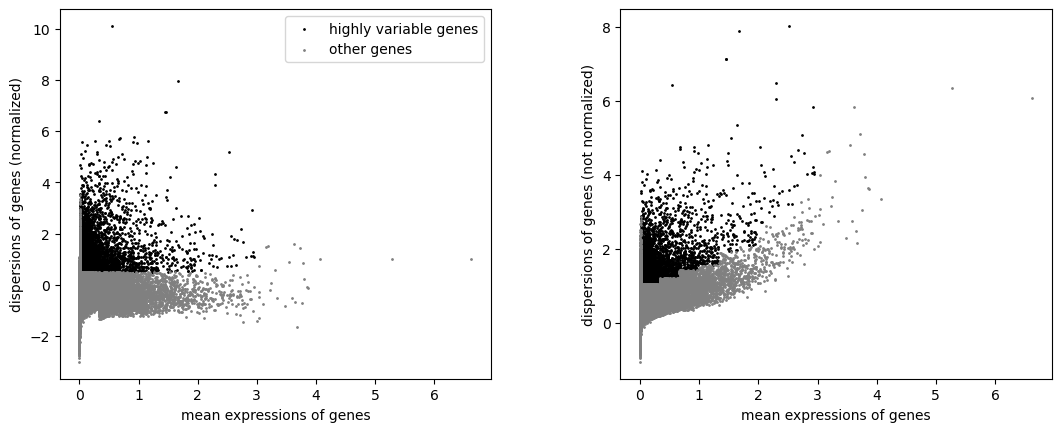

In [16]:
#STEP 9: ploting highly variable genes

# "highly variable genes" refers to genes that exhibit significant variation in expression across cells. These genes are often of particular interest because they can provide valuable insights into the biological heterogeneity and regulatory processes within a cell population.
# Identifying highly variable genes is an essential step in scRNA-seq analysis as it allows researchers to focus on genes that contribute most to the observed heterogeneity. 
# For pp.highly_variable_genes(): Expects logarithmized data, except when flavor='seurat_v3', in which count data is expected.

#In our case we are using default seurat so hvg is perfomed on log normailize gene data (this also filters out non hyg genes colored in grey)
sc.pp.highly_variable_genes(adata)
#post hvg filter: 18870 -> 4109

#how to read these HVG plots??
sc.pl.highly_variable_genes(adata)

In [17]:
#Step 10: filtering out and conserving only the highly variable genes

#The adata object has a property called var, which provides access to the variables (features) in the AnnData object. In the given code, adata.var['highly_variable'] is accessing the column named 'highly_variable' from the var property of the adata object. This column likely contains Boolean values indicating whether each variable is highly variable or not.

# the code adata = adata[:, adata.var['highly_variable']] filters the adata object to only retain the highly variable genes.
# adata[:, adata.var['highly_variable']], you are indexing the adata object to select all rows (:) but only the columns where the corresponding value in the 'highly_variable' column is True.

adata = adata[:, adata.var['highly_variable']]
print(adata)

View of AnnData object with n_obs × n_vars = 3005 × 4109
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [28]:
#Step 11: subsampling of adata

# Set the random seed to get consistent random sampling for t-sne
np.random.seed(0)

# Perform subsampling with seeded random number generator
subsampled_adata = sc.pp.subsample(adata, fraction=0.5, copy=True)

#print subsampled_adata
subsampled_adata

AnnData object with n_obs × n_vars = 1502 × 4109
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Based on the provided information, here is an interpretation of the AnnData object:

Shape: The AnnData object has dimensions of n_obs (number of observations) × n_vars (number of variables). In this case, it has 30 observations (likely representing cells) and 4109 variables (likely representing genes).

Observation metadata (obs): The AnnData object includes observation (cell) metadata fields, such as 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', and 'n_genes'. These fields contain additional information associated with each cell, such as sample identifiers, group assignments, molecular count information, demographic data, and classification information.

Variable metadata (var): The AnnData object has variable (gene) metadata fields, including 'n_cells', 'highly_variable', 'means', 'dispersions', and 'dispersions_norm'. These fields provide information specific to each gene.

'n_cells' denotes the number of cells in which each gene is detected.
'highly_variable' indicates whether each gene is classified as highly variable or not.
'means' represents the mean expression value of each gene across cells.
'dispersions' refers to the dispersion values of each gene, quantifying the variation in expression.
'dispersions_norm' represents the normalized dispersion values.
Unstructured data (uns): The AnnData object contains unstructured data, specifically the 'log1p' and 'hvg' entries. 'log1p' likely indicates that the expression values have been log-transformed by adding 1 to each value. 'hvg' might represent high-variance genes, suggesting that a specific analysis or filtering step has been applied to identify highly variable genes.

Overall, the AnnData object encapsulates single-cell RNA sequencing data with associated metadata and various calculated attributes. It provides a comprehensive representation of the cell-by-gene expression matrix, allowing for downstream analysis and exploration of the data.

The sc.tl.pca function in Scanpy performs principal component analysis (PCA) on the provided AnnData object (adata). PCA is a dimensionality reduction technique commonly used in single-cell RNA sequencing (scRNA-seq) data analysis to identify the major sources of variation and reduce the dimensionality of the data.

Here's a breakdown of the function and its parameters:

adata: This parameter is the AnnData object containing the scRNA-seq data you want to perform PCA on.

svd_solver: This parameter specifies the solver algorithm used to perform the singular value decomposition (SVD) during PCA. In this case, the value 'arpack' is provided, which is a common solver algorithm used for large sparse matrices. Other options include 'randomized' and 'auto', among others.

In [29]:
#Step 12: performing PCA

sc.tl.pca(subsampled_adata, svd_solver='arpack')

print(subsampled_adata)

AnnData object with n_obs × n_vars = 1502 × 4109
    obs: 'index', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'level1class', 'level2class', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


In [30]:
#Step 13: Running T-SNE (should Dim-Red before running)

# perplexity must be less than number of cells, and default perplexity is 30
# ran a test to iterate over the data values after normalization: none is < 0


sc.tl.tsne(subsampled_adata, perplexity = 30)


/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


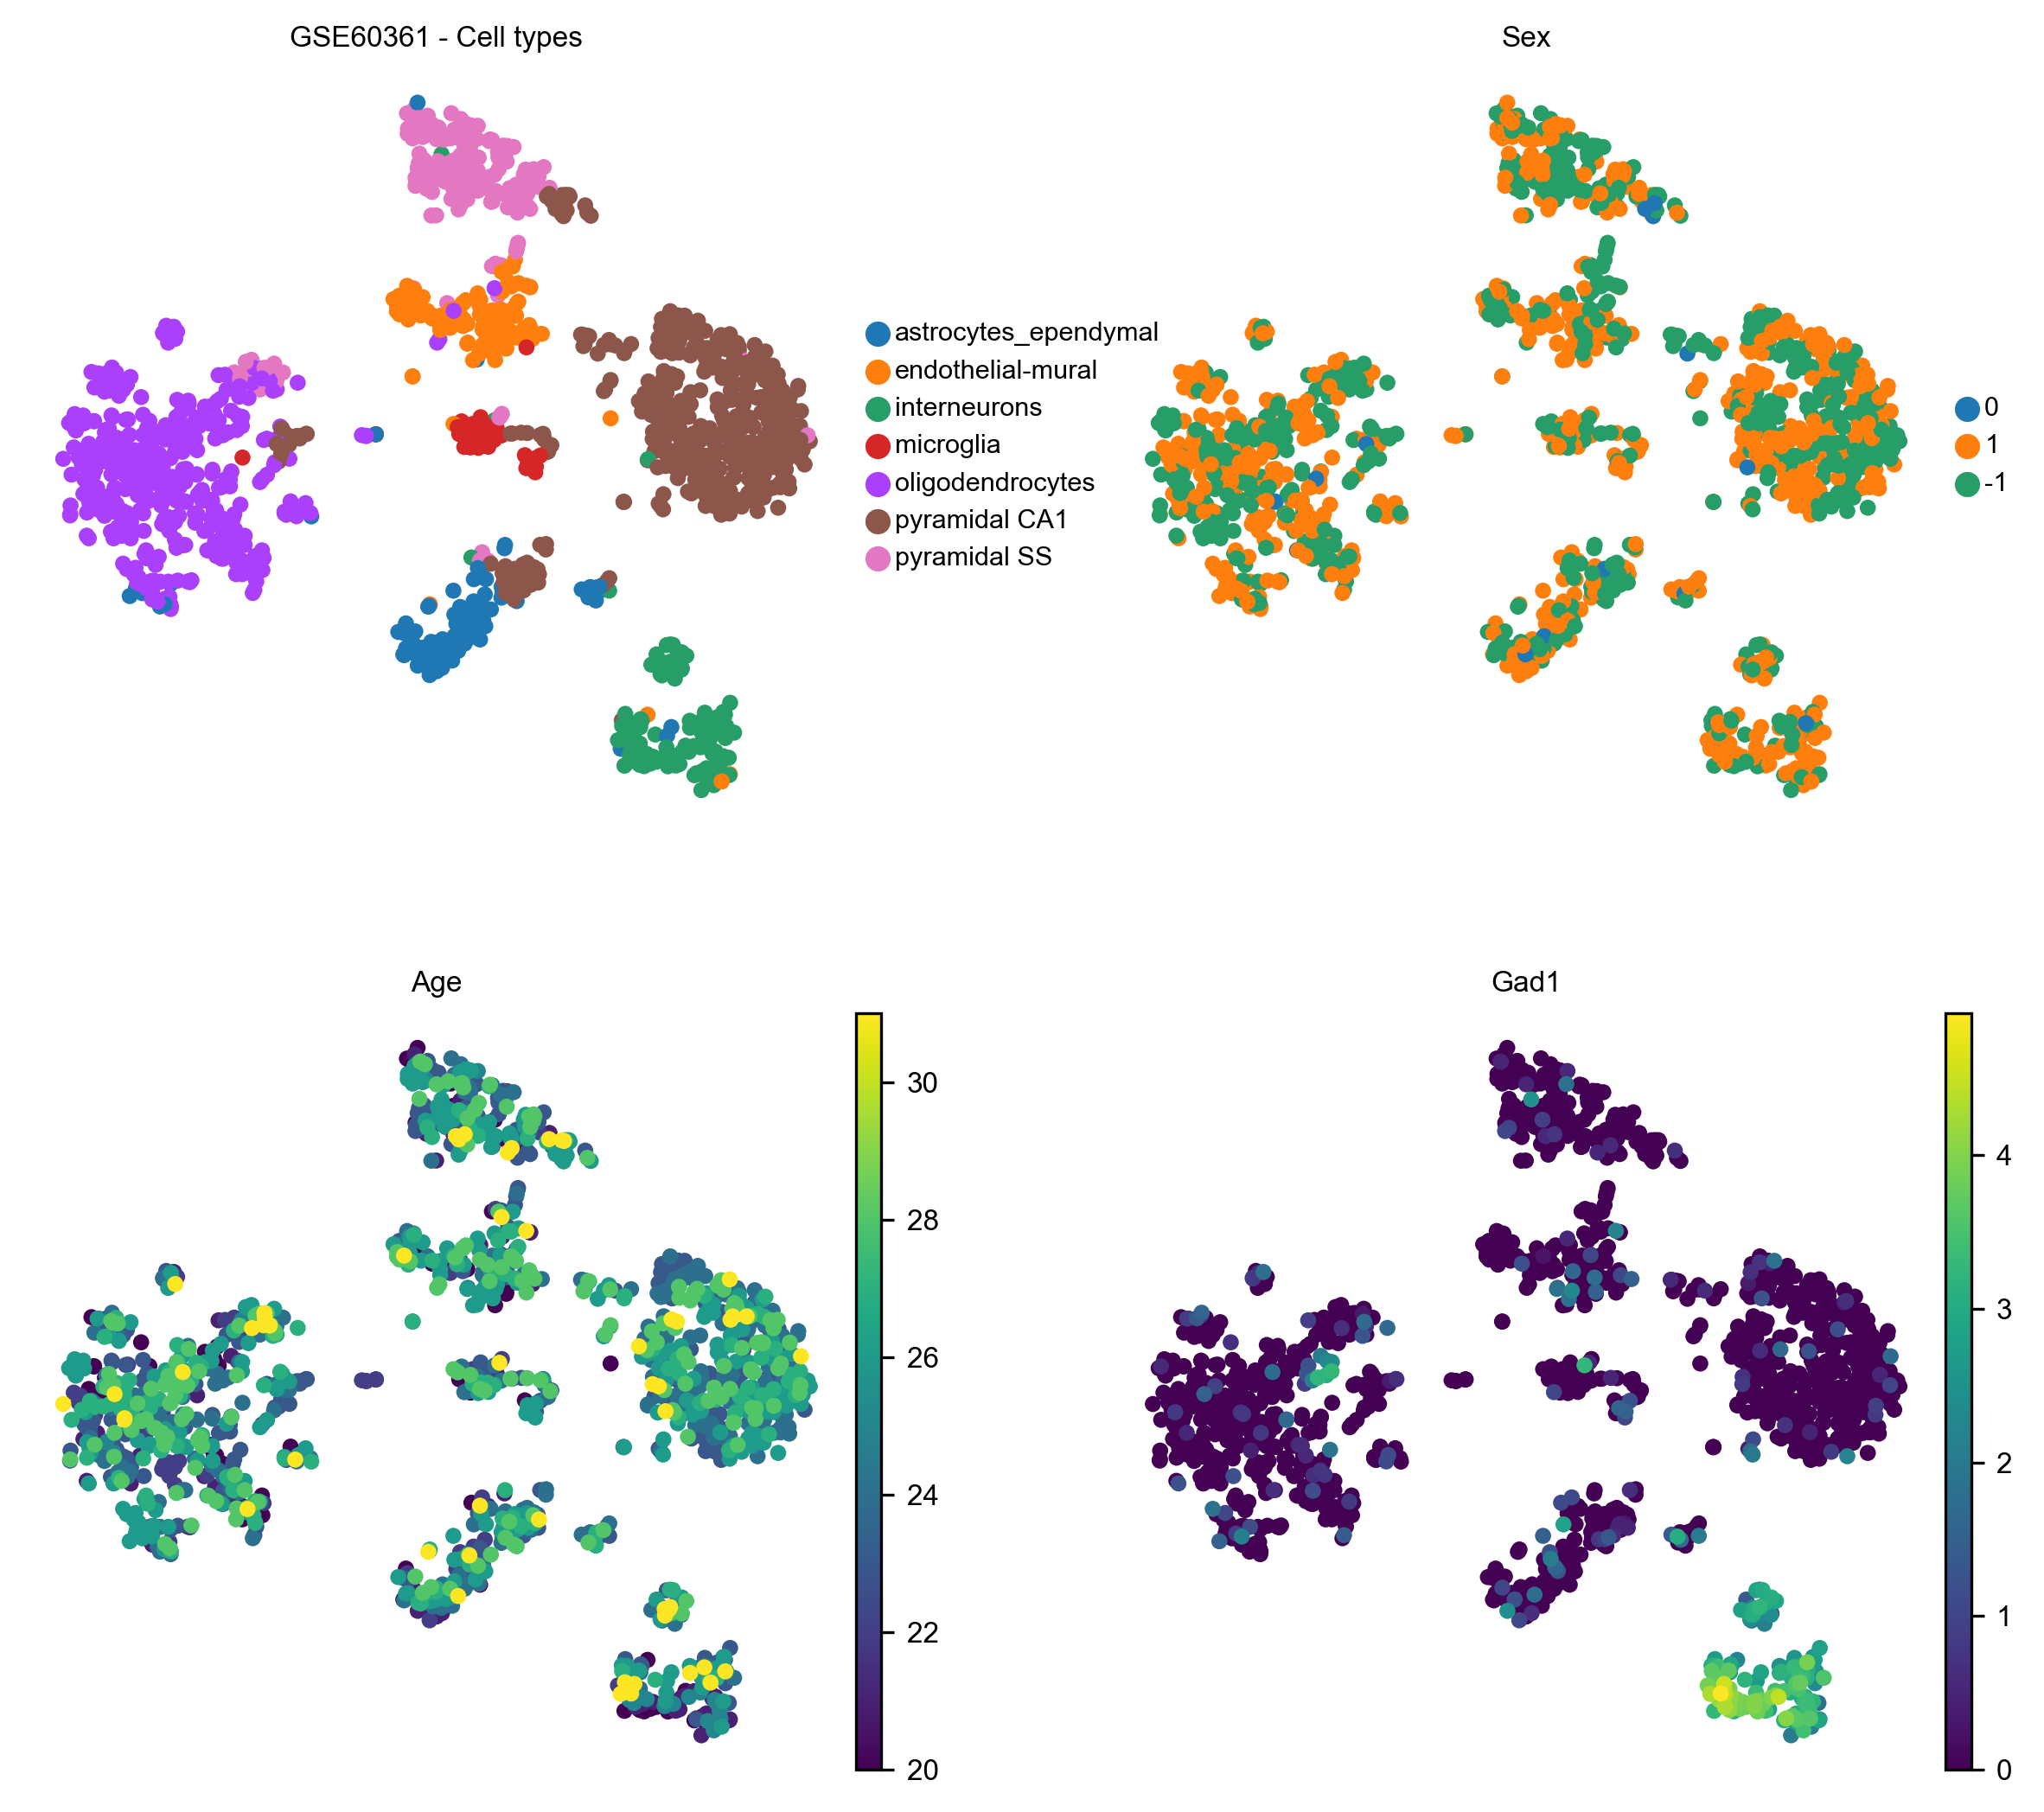

In [31]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(subsampled_adata, color=['level1class', 'sex', 'age', 'Gad1' ], 
           title=['GSE60361 - Cell types', 'Sex', 'Age', 'Gad1'], ncols=2, use_raw=False)

In [72]:
#Step pre-A: Checking expression file, subsample of cell pop and features in step 8 +

import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(COUNTS_QC_MTX_FNAME)

# Get the shape of the DataFrame
rows, columns = df.shape

# Print the number of rows and columns
print("Number of rows:", rows)
print("Number of columns:", columns)

Number of rows: 30
Number of columns: 101


In [73]:
# STEP A: running SCENIC GRNBoost

#input file: in results folder is the dataframe file with raw counts (currently subsamples from step 8) and also mouse TF list
#output: csv file with three columns: the TF, its target, the importance of the TF on that target

!pyscenic grn {COUNTS_QC_MTX_FNAME} {MM_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 32

/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/Users

In [79]:
#STEP B: Regulon construction with cistarget/iRegulon

#Importing all the ranking files (each 1 gb) to one pathway variable
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)


In [80]:
!pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} --annotations_fname {MOTIF_ANNOTATIONS_FNAME} --expression_mtx_fname {COUNTS_QC_MTX_FNAME} --output {MOTIFS_FNAME} --num_workers 26

/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/Users/leeker/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/Users